## Simulation Results

This notebook implements the methods proposed in Agarwal et al. (2024) on a simulated acceleration data using a heirarchical model. 



In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import time
nb_start_time = time.time()

In [5]:
# import libraries
import json
import sys
import os
from tqdm import tqdm
from tqdm import trange
import pandas as pd
import numpy as np
import torch
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random 
import matplotlib.patches as patches
import pickle

sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')

In [6]:
# import scripts

import config as config
from scripts.matching import match_behaviors
import src.data_prep.create_segments_and_metadata as create_segments_and_metadata
import src.data_prep.data_prep_utils as data_prep_utils
import src.data_prep.create_matched_data_objects as create_matched_data_objects
import src.utils.data as utils_data
import src.utils.io as utils_io
import src.utils.plot as utils_plot
from src.methods.prediction_model import create_dynamic_conv_model
from src.utils.train import (train_run)
from src.utils.plot import(multi_label_predictions,
                            plot_signal_and_online_predictions)
from src.methods.online_predictions import (online_score_evaluation,
                                            online_smoothening)
from src.utils.simulations import (plot_simulated_day,
                                    simulate_fourier_signal,
                                    generate_acc_data,
                                    simulate_axis_signal,
                                    simulate_markov_acc_day,
                                    generate_dataset)
from dataclasses import dataclass

In [7]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams['legend.fontsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.title_fontsize'] = 30
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

In [8]:
def set_seed(seed):
    random.seed(seed)                     # Python random module
    np.random.seed(seed)                  # NumPy
    torch.manual_seed(seed)               # PyTorch CPU
    torch.cuda.manual_seed(seed)          # PyTorch GPU

set_seed(0)

### Heirarchical Model

The hierarchical model used to simulate the acceleration signal $X_a(t)$, along axis $a$ (out of $x, y, z$ axes) given a behaviour label $y$ is given by:
$$
    X_a(t) \mid (Y=y) = \sum_{c=1}^C A_{y, a}^c \sin \left(2\pi F_{y, a}^c t + \Phi_{y,a}^c\right) + Z_{y, a}, \quad \text{where} \quad
Z_{y, a} \sim \mathcal{N}\left({0, \Sigma_{y, a}}\right).
$$
Thus, the signal is modeled as a sum of $C$ (random) sinusoids with added Gaussian noise. For each behaviour $y$ and axis $a$, the parameters of the $c$th sinusoid are the amplitude $A_{y, a}^c$, frequency $F_{y, a}^c$, and phase shift $\Phi_{y, a}^c$. The parameter for the Gaussian noise is variance $\Sigma_{y, a}$. These parameters are randomly perturbed from fixed values as follows:
\begin{align*}
A_{y, a}^c = a_{y, a}^c + U_1, \quad \quad  F_{y, a}^c = f_{y, a}^c + U_2, \quad \quad \Phi_{y, a}^c = \phi_{y, a}^c + U_3, \quad \quad \Sigma_{y,a} = \sigma_{y,a} + U_4,
\end{align*}
where $U_i$, $i\in\{1, \dots, 4\}$ are independent and identically distributed random variables. In summary, the parameters $\left({A_{y, a}^c, F_{y, a}^c, \Phi_{y, a}^c, \Sigma_{y, a}}\right)$ are defined as uniform perturbations (in the interval $[-\tau, \tau]$) of constants $\left({a_{y, a}^c, f_{y, a}^c, \phi_{y, a}^c, \sigma_{y, a}}\right)$. We set $C = 3$. The specific hyperparameter values of $\left({a_{y, a}^c, f_{y, a}^c, \phi_{y, a}^c, \sigma_{y, a}, \tau}\right)$ used for the training set are detailed below.

| Behaviour | Axis | **f**               | **A**               | **φ**              | **σ**  |
|-----------|------|---------------------|---------------------|--------------------|--------|
| Feeding   | X    | (1.0, 3.0, 5.0)     | (1.0, 2.0, 3.0)     | (0.2, 0.7, 1.2)    | 1.0    |
| Feeding   | Y    | (2.0, 3.0, 4.0)     | (2.0, 3.0, 4.0)     | (0.3, 0.8, 1.3)    | 1.0    |
| Feeding   | Z    | (3.5, 4.5, 5.5)     | (3.5, 4.5, 5.5)     | (0.4, 0.9, 1.4)    | 1.0    |
| Moving    | X    | (1.4, 3.4, 5.4)     | (1.4, 3.4, 5.4)     | (0.6, 1.2, 1.8)    | 1.0    |
| Moving    | Y    | (2.4, 3.4, 4.4)     | (2.4, 3.4, 4.4)     | (0.5, 1.0, 1.5)    | 1.0    |
| Moving    | Z    | (3.1, 4.1, 5.1)     | (3.1, 4.1, 5.1)     | (0.7, 1.2, 1.8)    | 1.0    |
| Resting   | X    | (0.5, 1.0, 1.5)     | (0.5, 1.0, 1.5)     | (0.0, 0.1, 0.2)    | 0.5    |
| Resting   | Y    | (1.0, 1.5, 2.0)     | (1.0, 1.5, 2.0)     | (0.0, 0.1, 0.2)    | 0.5    |
| Resting   | Z    | (1.5, 2.0, 2.5)     | (1.5, 2.0, 2.5)     | (0.0, 0.1, 0.2)    | 0.5    |
| Vigilant  | X    | (0.8, 1.3, 1.8)     | (0.8, 1.3, 1.8)     | (0.0, 0.3, 0.6)    | 0.5    |
| Vigilant  | Y    | (0.7, 1.2, 1.7)     | (0.7, 1.2, 1.7)     | (0.0, 0.4, 0.8)    | 0.5    |
| Vigilant  | Z    | (1.8, 2.3, 2.8)     | (1.8, 2.3, 2.8)     | (0.0, 0.5, 1.0)    | 0.5    |

In [9]:
test_root_dir = config.TEST_ROOT_DIR
os.makedirs(test_root_dir, exist_ok=True)

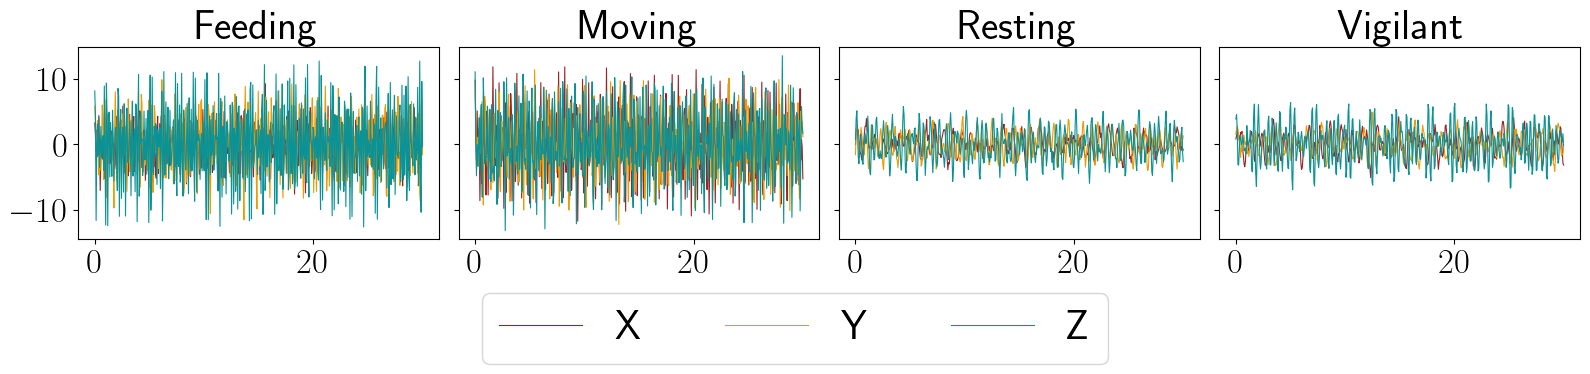

In [10]:
t = np.linspace(0, 30, 30*config.SAMPLING_RATE)
data_constants = config.SIMULATION_CONSTANTS
colors = ['#9b2226', '#ee9b00', '#0a9396']
fig, axs = plt.subplots(1, len(config.SIM_BEHAVIORS), figsize=(4*len(config.SIM_BEHAVIORS),3), sharey=True)
for i, observed_behavior in enumerate(config.SIM_BEHAVIORS):
    for j, axis in enumerate(['X', 'Y', 'Z']):
        f, A, phi, sigma = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == axis), ['f', 'A', 'phi', 'sigma']].values[0]
        signal = simulate_axis_signal(f, A, phi, sigma, len(t), tau=0.35)

        if i == 0:
            axs[i].plot(t, signal, label=axis, linewidth=0.8, color=colors[j])
        else:
            axs[i].plot(t, signal, linewidth=0.8, color=colors[j])

    axs[i].set_title(observed_behavior)

fig.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5,-0.3))
plt.tight_layout()
plt.savefig(os.path.join(test_root_dir, 'sim_train_signal.pdf'))
plt.show()

## Result 1: Class Imbalance

We simulate data with extreme class imabalance. We assume the following class distribution for the behaviors of interest.


| Behavior | Probability of occurence |
|----------|--------------------------|
| Feeding  |  0.05   |
| Moving   | 0.4 |
| Resting  | 0.45 |
| Vigilant | 0.1 |

In [11]:
# define paths

# Create directories and generate acceleration data
results_dir = os.path.join(config.TEST_ROOT_DIR, "class_imbalance")
os.makedirs(results_dir, exist_ok=True)

training_results_dir = os.path.join(results_dir, "training_results")
os.makedirs(training_results_dir, exist_ok=True)

plots_dir = os.path.join(results_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

In [12]:
class_dist = dict(zip(config.SIM_BEHAVIORS, [0.05, 0.4, 0.45, 0.1]))

window_length = int(30.0 * config.SAMPLING_RATE)

label_encoder = LabelEncoder()
label_encoder.fit(config.SIM_BEHAVIORS)

data_constants = config.SIMULATION_CONSTANTS

In [13]:

@dataclass
class Arguments:
    experiment_name: str
    batch_size: int
    window_duration_percentile: float
    train_test_split: float
    train_val_split: float
    padding: str
    theta: float
    filter_type: str
    cutoff_frequency: float
    cutoff_order: int
    normalization: int
    match: int
    min_duration: float
    n_CNNlayers: int
    n_channels: int
    kernel_size: int
    learning_rate: float
    weight_decay: float
    num_epochs: int
    alpha: float
    verbose: int

args = Arguments(
    experiment_name='no_split', batch_size=64, window_duration_percentile=20, 
    train_test_split=0.2, train_val_split=0.2, padding='repeat', theta=0.0, 
    filter_type='high', cutoff_frequency=0, cutoff_order=5, normalization=0,
    match=0, min_duration=1.0, n_CNNlayers=3, n_channels=16, kernel_size=5,
    learning_rate=0.0001, weight_decay=0.0001, num_epochs=100, alpha=0.05, verbose=0
)

args.experiment_name = 'test_interyear'


In [14]:
n_train, n_test = 5000, 1000
training_file_path = os.path.join(training_results_dir, 'training_data.npz')

if os.path.exists(training_file_path):
    print("Loading existing training data...")
    data = np.load(training_file_path)
    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']
    X_test = data['X_test']
    y_test = data['y_test']
else:
    print("Generating new training data...")
    X, y = generate_dataset(data_constants, class_dist, window_length, n_train, wrong_behavior=True, wrong_behavior_prob=0.075, tau=0.35)
    X_test, y_test = generate_dataset(data_constants, class_dist, window_length, n_test, tau=0.4)

    print(np.unique(y, return_counts=True))
    y, y_test = label_encoder.transform(y), label_encoder.transform(y_test)

    # First split: train_val vs test
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(sss1.split(np.zeros(n_train), y))

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    print(f"{'X train shape':<15} {X_train.shape} {'X val shape':<15} {X_val.shape} {'X test shape':<15} {X_test.shape}")

    class_imbalance_data = {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
    }
    np.savez(training_file_path, **class_imbalance_data)

n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(y_train))
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

Loading existing training data...


In [ ]:
thetas = np.round(0.2*np.arange(0, 6), 1)
for i, theta in enumerate(thetas):

    training_data = np.load(os.path.join(training_results_dir, 'training_data.npz'))
    X_train, y_train, X_val, y_val, X_test, y_test = training_data['X_train'], training_data['y_train'], training_data['X_val'], training_data['y_val'], training_data['X_test'], training_data['y_test']

    args.theta = theta
    train_dataloader, val_dataloader, test_dataloader = utils_data.setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)


    # Define the sequential model
    model = create_dynamic_conv_model(n_features, n_timesteps, n_outputs, 
                                            num_conv_layers=args.n_CNNlayers, 
                                            base_channels=args.n_channels, 
                                            kernel_size=args.kernel_size).to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

    #### Training
    train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, args, device)
    model = train_obj['model']
    training_stats = train_obj['training_stats']

    model_dir = os.path.join(training_results_dir, f"theta{theta}")
    os.makedirs(model_dir, exist_ok=True)

    torch.save(model, os.path.join(model_dir, 'model.pt'))
    json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
    with open(json_training_stats_file, 'w') as f:
        json.dump(training_stats, f)

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
    np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
    np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
    np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
    np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])


In [16]:
training_data = np.load(os.path.join(training_results_dir, 'training_data.npz'))
X_train, y_train, X_val, y_val, X_test, y_test = training_data['X_train'], training_data['y_train'], training_data['X_val'], training_data['y_val'], training_data['X_test'], training_data['y_test']

In [17]:
def plot_raw_time_series(X, y, save_path=None):
    """
    Plot raw time series data for each unique class in y.

    Parameters:
    - X (np.ndarray): 3D array of time series data with shape (n_samples, n_channels, n_time_steps).
    - y (np.ndarray): Array of class labels corresponding to each sample in X.
    """

    unique_classes = np.unique(y)
    n_classes = len(unique_classes)

    fig, axs = plt.subplots(1, n_classes, figsize=(4 * n_classes, 4), sharex=True, sharey=True)
    if n_classes == 1:
        axs = [axs]

    # custom_palette = sns.color_palette("husl", 3)
    custom_palette = ['#9b2226', '#0a9396', '#ee9b00']
    handles = []
    labels = []

    for j, cls in enumerate(unique_classes):
        i = np.random.choice(np.where(y == cls)[0])
        time = np.linspace(0, X.shape[2] / 16, X.shape[2])

        # Plot each channel with corresponding colors
        for k, label in enumerate(['X', 'Y', 'Z']):
            line, = axs[j].plot(time, X[i, k, :], label=label, color=custom_palette[k], linewidth=1.2, alpha=0.6)
            if j == 0:  # Collect handles and labels only from the first subplot
                handles.append(line)
                labels.append(label)

        # Set title for the subplot
        axs[j].set_title(f'{cls}')
        axs[j].set_xlabel('Time (s)')

    axs[0].set_ylabel('Amplitude (g)')
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2))

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

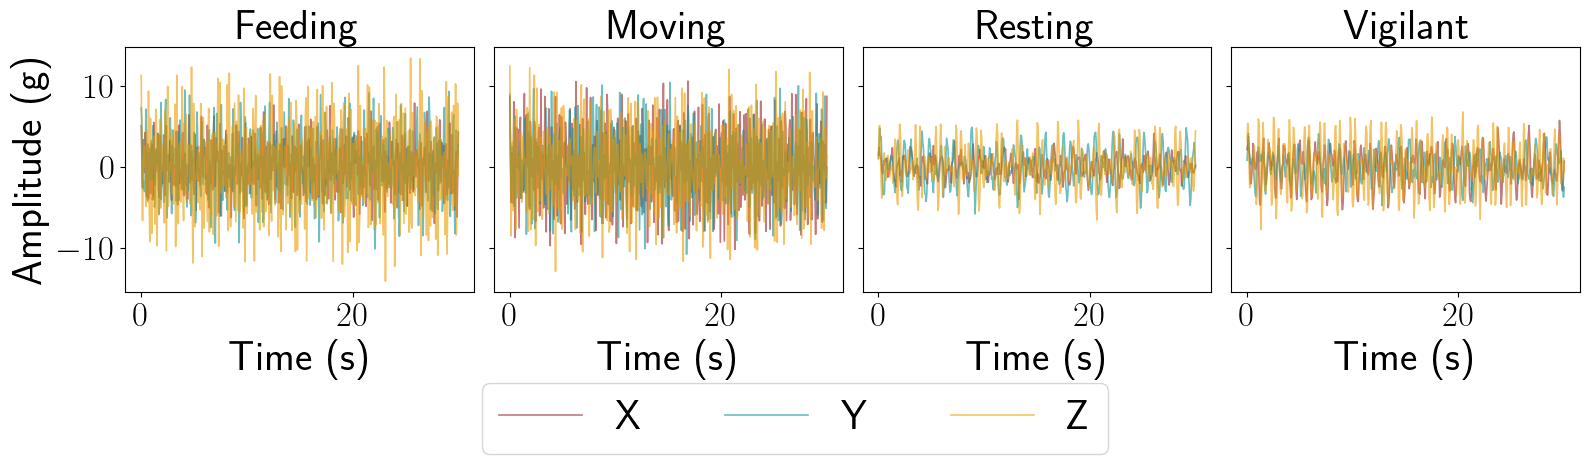

In [18]:
plot_raw_time_series(X_test, label_encoder.inverse_transform(y_test))

Let us plot the training and validation loss.

In [19]:
dir = os.path.join(training_results_dir, f"theta0.0")
json_training_stats_file = os.path.join(dir, 'training_stats.json')

with open(json_training_stats_file, 'r') as f:
    training_stats = json.load(f)

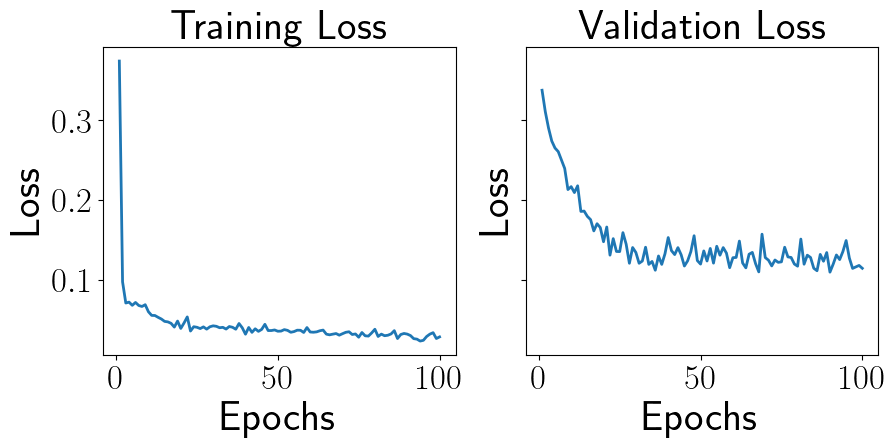

In [20]:
#plot training stats
training_stats = pd.DataFrame(training_stats)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].plot(training_stats['epoch'], training_stats['Training Loss'])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")

axs[1].plot(training_stats['epoch'], training_stats['Validation Loss'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Validation Loss")
plt.show()

[0.79221449 0.82563988 0.82269133 0.81908739 0.84627713 0.83658903]


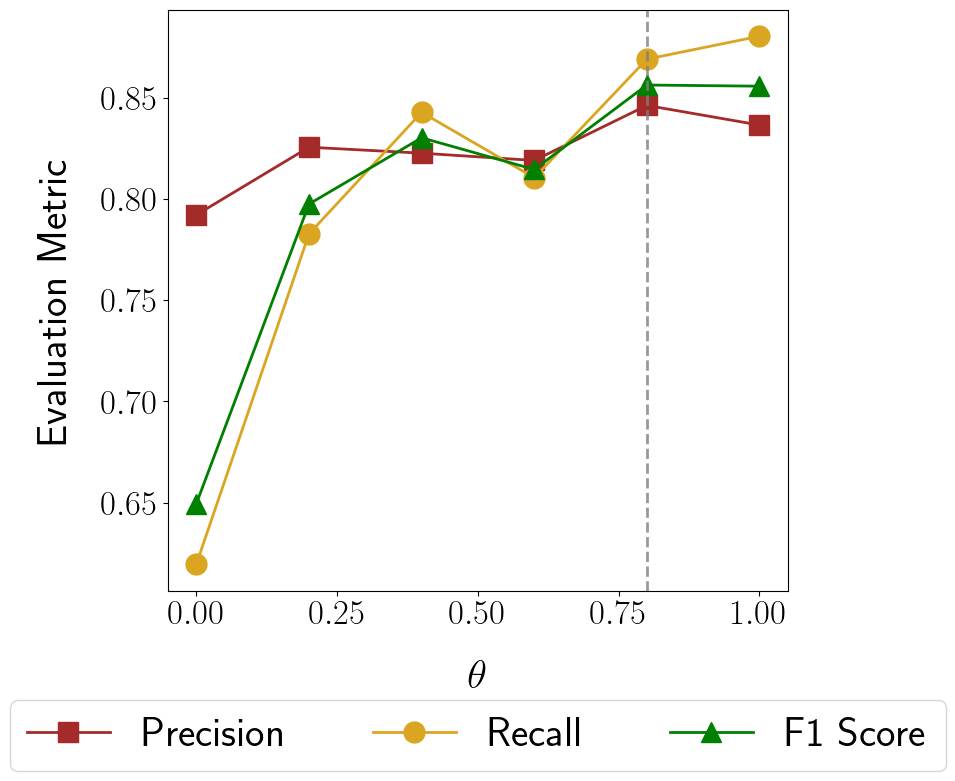

In [21]:

thetas = np.round(0.2*np.arange(0, 6), 1)
colors = ['brown', 'goldenrod', 'green']

precisions = np.zeros(len(thetas))
recalls = np.zeros(len(thetas))
f1scores = np.zeros(len(thetas))

for i, theta in enumerate(thetas):
    dir = os.path.join(training_results_dir, f"theta{theta}")
    # dir = os.path.dirname(os.path.dirname(dir))
    precisions[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)


print(precisions)

plt.figure(figsize=(9,8))
plt.plot(thetas, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(thetas, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(thetas, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.axvline(0.8, color='grey', alpha=0.8, linestyle='--')
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)
plt.legend(loc='center', bbox_to_anchor=(.5, -0.25), ncol=3)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'class_imbalance-theta_tuning.png'), dpi=300, format="png", bbox_inches="tight")

plt.show()

<Figure size 640x480 with 0 Axes>

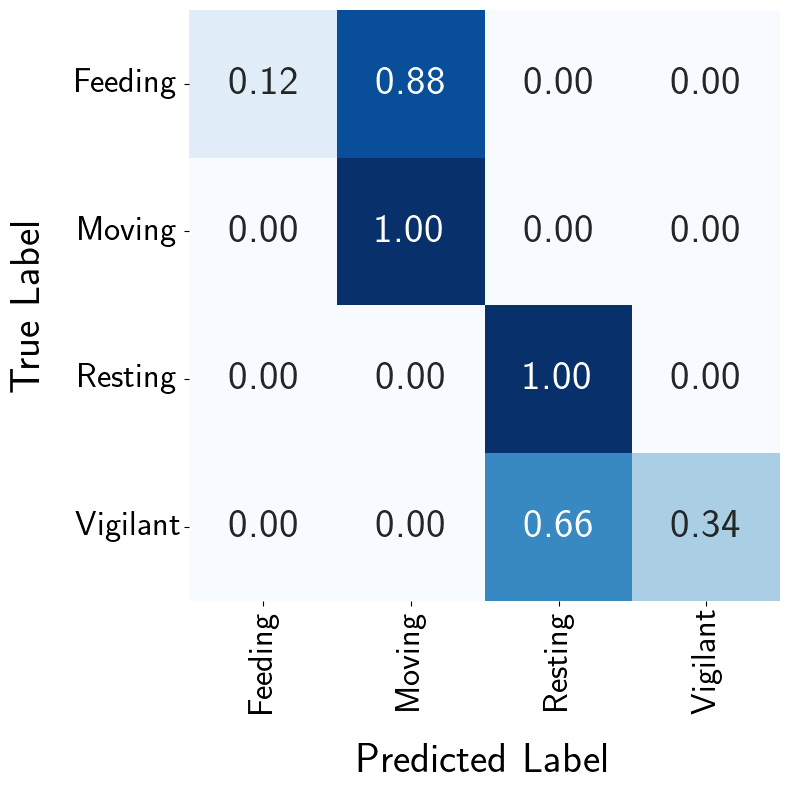

In [22]:
dir = os.path.join(training_results_dir, f"theta0.0")
y= np.load(os.path.join(dir, 'test_true_classes.npy'))
y_hat= np.load(os.path.join(dir, 'test_predictions.npy'))

multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=os.path.join(plots_dir, 'class_imbalance-confusion_matrix_theta0.0.png'))

<Figure size 640x480 with 0 Axes>

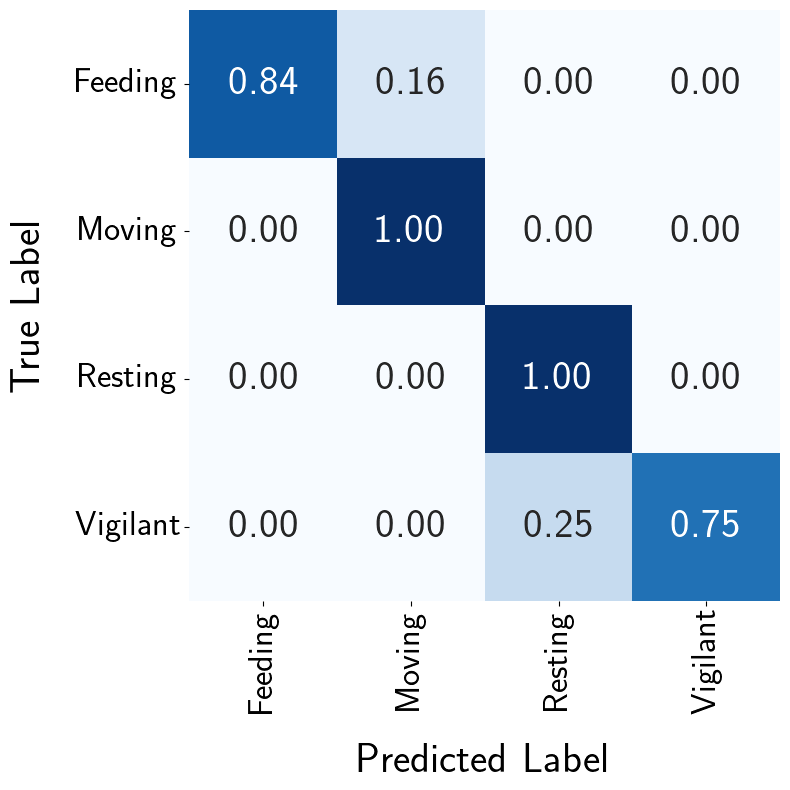

In [23]:
dir = os.path.join(training_results_dir, f"theta0.6")
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=os.path.join(plots_dir, 'class_imbalance-confusion_matrix_theta0.8.png'))

In [24]:
dir = os.path.join(training_results_dir, f"theta1.0")
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True)

0.98

## Result 2: Uncertainty Quantification

We construct the prediction sets for our model trained with $\theta = 0.8$.

In [25]:
from src.methods.conformal_prediction import *
from src.utils.conformal import *
import torch.nn.functional as F

model_dir = os.path.join(training_results_dir, f"theta0.8")
training_data = np.load(os.path.join(training_results_dir, 'training_data.npz'))
X_train, y_train, X_val, y_val, X_test, y_test = training_data['X_train'], training_data['y_train'], training_data['X_val'], training_data['y_val'], training_data['X_test'], training_data['y_test']

device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

if device == torch.device("cpu"):
    model = torch.load(os.path.join(model_dir, 'model.pt'), map_location=torch.device('cpu'), weights_only=False)
else:
    model = torch.load(os.path.join(model_dir, 'model.pt'), weights_only=False)

cdataloader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=args.batch_size, shuffle=False)
cmodel = ConformalModel(model, cdataloader, alpha=0.05, randomized=True, lamda_criterion='size').to(device)
torch.save(cmodel, os.path.join(model_dir, 'cmodel.pt'))

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 16/16 [00:00<00:00, 910.01it/s]


Optimal T=0.4932440519332886


In [35]:
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

N: 1000 | Avg Time: 0.003 | Avg Cvg@1: 0.965 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.987 | Avg Size@RAPS: 1.114



As an example, there are a total of 6 **feeding** labels that are incorrectly predicted as **moving** by the most-likely prediction. 

In [36]:
logits, psets = cmodel(torch.Tensor(X_test).float().to(device))
softmax_scores = F.softmax(logits, dim=-1)
softmax_scores = softmax_scores.detach().cpu().numpy()
most_likely = np.argmax(softmax_scores, axis=-1)
idx = np.where(((y_test == 0) | (y_test == 1)) & (most_likely != y_test))[0]
for id in idx:
    print(f"{str(label_encoder.inverse_transform(psets[id])):<20} with scores {softmax_scores[id][list(psets[id])]}")

['Moving']           with scores [0.36745983]
['Moving' 'Feeding'] with scores [0.37742993 0.25236565]
['Moving' 'Feeding'] with scores [0.3534641  0.29222152]
['Moving' 'Feeding'] with scores [0.32227147 0.2950895 ]
['Moving' 'Feeding'] with scores [0.3315474  0.33010307]
['Moving' 'Feeding'] with scores [0.3244768  0.30508524]
['Moving']           with scores [0.36262205]
['Moving' 'Feeding'] with scores [0.32912666 0.3051316 ]
['Moving' 'Feeding'] with scores [0.3471398 0.2768225]
['Moving' 'Feeding'] with scores [0.327613  0.3182884]


In [37]:
print(f"{np.round(((1-no_split_test_top1) - (1-no_split_test_coverage)) / (1-no_split_test_top1), 5)}% of incorrectly predicted observations are in the RAPS.")

0.62857% of incorrectly predicted observations are in the RAPS.


In [38]:
for observed_behavior in config.SIM_BEHAVIORS:
    print(observed_behavior)
    label = label_encoder.transform([observed_behavior])
    mask = (y_test == label)
    ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[mask], dtype=torch.float32), torch.tensor(y_test[mask])), batch_size=args.batch_size, shuffle=False)
    no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

    

Feeding
N: 46 | Avg Time: 0.004 | Avg Cvg@1: 0.783 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.957 | Avg Size@RAPS: 1.674

Moving
N: 379 | Avg Time: 0.004 | Avg Cvg@1: 1.000 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 1.000 | Avg Size@RAPS: 1.000

Resting
N: 465 | Avg Time: 0.003 | Avg Cvg@1: 1.000 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 1.000 | Avg Size@RAPS: 1.028

Vigilant
N: 110 | Avg Time: 0.003 | Avg Cvg@1: 0.773 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.945 | Avg Size@RAPS: 1.691



In [40]:
test_scores = np.load(os.path.join(model_dir, 'test_scores.npy'))
mask = (np.max(test_scores, axis=1) < 0.5)

# test observations with high score
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[mask], dtype=torch.float32), torch.tensor(y_test[mask])), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

# test observations with low score
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[~mask], dtype=torch.float32), torch.tensor(y_test[~mask])), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

N: 8 | Avg Time: 0.006 | Avg Cvg@1: 0.750 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 1.000 | Avg Size@RAPS: 1.875

N: 992 | Avg Time: 0.004 | Avg Cvg@1: 0.967 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.989 | Avg Size@RAPS: 1.117



#### Comparing the time spent in each behavior

In [23]:
# Create directories and generate acceleration data
results_dir = os.path.join(config.TEST_ROOT_DIR, "uncertainty_quantification")
os.makedirs(results_dir, exist_ok=True)

plots_dir = os.path.join(results_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

In [159]:
transition_matrix = np.array([
    [0.0, 0.7, 0.0, 0.3],  # from Feeding
    [0.5, 0.0, 0.3, 0.2],  # from Moving
    [0.0, 0.7, 0.0, 0.3],  # from Resting
    [0.0, 0.5, 0.5, 0.0],  # from Vigilant
])
avg_durations = {
    "Feeding": {"min": 60, "sec": 60},
    "Moving": {"min": 240, "sec": 60},
    "Resting": {"min": 360, "sec": 60},
    "Vigilant": {"min": 120, "sec": 60}
}
# Convert to DataFrame
avg_durations = pd.DataFrame.from_dict(avg_durations, orient="index")
avg_durations.index.name = "Behavior"
avg_durations.columns.name = "DurationUnit"

acc_df, annotations_df = simulate_markov_acc_day(config.SIMULATION_CONSTANTS, transition_matrix, avg_durations, tau=0.4)
acc_df.to_csv(os.path.join(results_dir, 'acc_df.csv'))
annotations_df.to_csv(os.path.join(results_dir, 'annotations_df.csv'))

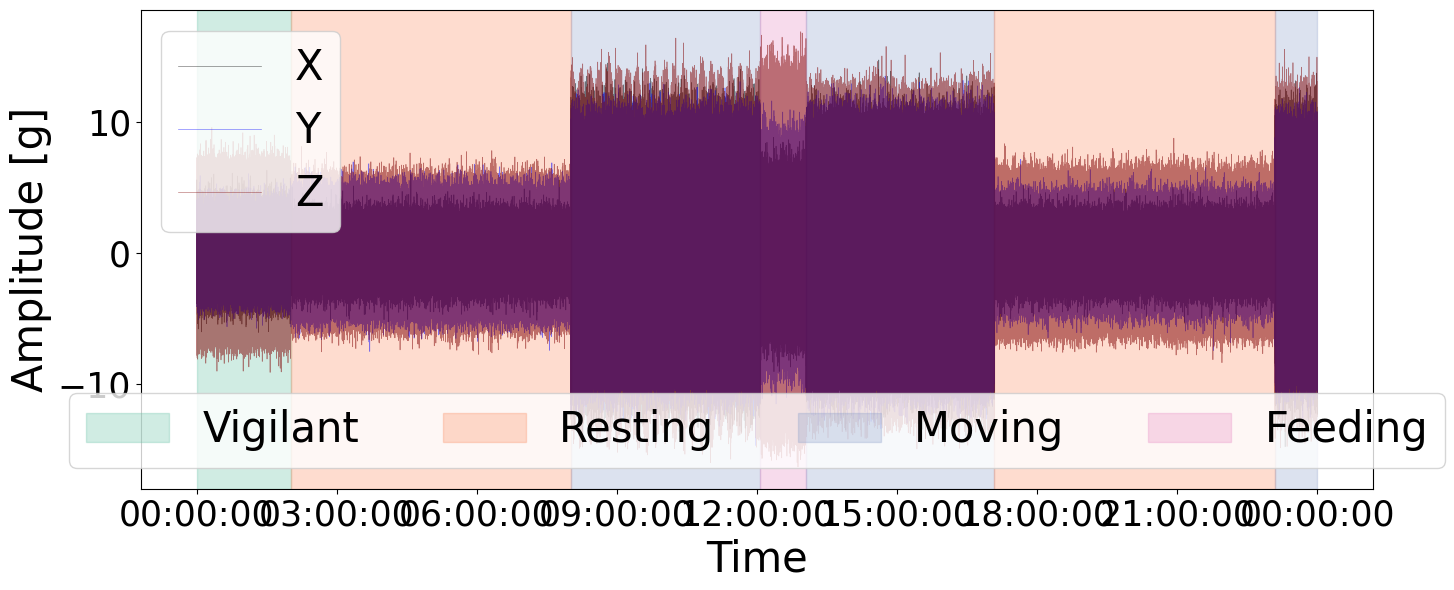

In [160]:
acc_df = pd.read_csv(os.path.join(results_dir, 'acc_df.csv'))
annotations_df = pd.read_csv(os.path.join(results_dir, 'annotations_df.csv'))

plot_simulated_day(acc_df)

The time spent in each behavior for a simulated 24 hours accelerationbehavior data is displayed below.

In [161]:
window_duration = 30.0
window_length = int(window_duration * config.SAMPLING_RATE)

acc_df['Timestamp'] = pd.to_datetime(acc_df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
acc_df.sort_values(by='Timestamp', inplace=True)
signal = torch.tensor(np.array([acc_df['Acc X [g]'].values, acc_df['Acc Y [g]'].values, acc_df['Acc Z [g]'].values])).float().unsqueeze(0)
smoothening_config = {'smoothening_window_length': 1,
                          'smoothening_hop_length': 1,
                          'score_hop_length': None
                          }
scores = online_score_evaluation(model_dir=model_dir, 
                                X=signal, window_duration=window_duration, 
                                window_length=None, hop_length=smoothening_config['score_hop_length'], 
                                sampling_frequency=config.SAMPLING_RATE)

behavior_counts = acc_df['Behavior'].value_counts()
behavior_durations = (behavior_counts / config.SAMPLING_RATE)/3600

print("Time Spent in Each Behavior for the simulated data")
print(behavior_durations)

Time Spent in Each Behavior for the simulated data
Behavior
Resting     12.012361
Moving       8.992361
Vigilant     2.012014
Feeding      0.982917
Name: count, dtype: float64


In [162]:
top1_behaviors = np.argmax(scores, axis=1)  # shape (1, B, W)
unique, counts = np.unique(top1_behaviors, return_counts=True)

total_top1_durations = dict(zip(label_encoder.inverse_transform(unique), np.round(counts *32/3600, 4)))
print("TOP-1 PREDICTION DURATIONS")
print(total_top1_durations)

TOP-1 PREDICTION DURATIONS
{np.str_('Feeding'): np.float64(0.88), np.str_('Moving'): np.float64(9.7689), np.str_('Resting'): np.float64(12.8444), np.str_('Vigilant'): np.float64(2.0978)}


In [163]:
@dataclass
class BehaviorMetrics:
    duration: float
    count: int
    raps_cvg: int
    top1_cvg: int
        
total_raps_metrics = {behavior: BehaviorMetrics(duration=0.0, count=0, raps_cvg=0, top1_cvg=0) for behavior in config.SIM_BEHAVIORS}
multiple_behavior_count = 0
window_length = int(window_duration * config.SAMPLING_RATE)
hop_length = window_length

# check if model and window duration are compatible
cmodel = torch.load(os.path.join(model_dir, 'cmodel.pt'), weights_only=False).to(device)

zero_signal = torch.zeros(1, 3, window_length).to(device)
assert cmodel.model[:-2](zero_signal).shape[-1] == cmodel.model[-2].in_features, "Window duration and model not compatible"

signal = signal[:, :, (signal.shape[2] - window_length) % hop_length : ]
signal_behaviors = acc_df['Behavior'][(signal.shape[2] - window_length) % hop_length : ].values
confusing_obs = []

for i in range(1 + (signal.shape[2] - window_length)//hop_length):
    X_temp = signal[:, :, i*hop_length : i*hop_length+window_length]
    X_temp_behaviors = signal_behaviors[i*hop_length : i*hop_length+window_length]
    
    with torch.no_grad():
        outputs, pset = cmodel(X_temp.to(device))
    pset = label_encoder.inverse_transform(pset[0])

    if len(list(pset)) > 1:
        confusing_obs.append({'signal': X_temp, 'pset': pset, 'true_behavior': X_temp_behaviors[0]})

    for b in list(pset):
        total_raps_metrics[b].duration += np.round(window_duration/3600, 4)

    if X_temp_behaviors[0] == X_temp_behaviors[-1]:
        window_behavior = X_temp_behaviors[0]
        total_raps_metrics[window_behavior].count += 1

        if window_behavior == label_encoder.inverse_transform([np.argmax(outputs.cpu().numpy())])[0]:
            total_raps_metrics[window_behavior].top1_cvg += 1

        if window_behavior in list(pset):
            total_raps_metrics[window_behavior].raps_cvg += 1
    else:
        multiple_behavior_count += 1
        window_behavior = X_temp_behaviors[-1]
        total_raps_metrics[window_behavior].count += 1

        if window_behavior == label_encoder.inverse_transform([np.argmax(outputs.cpu().numpy())])[0]:
            total_raps_metrics[window_behavior].top1_cvg += 1

        if window_behavior in list(pset):
            total_raps_metrics[window_behavior].raps_cvg += 1


raps_summary = pd.DataFrame.from_dict({k: (v.duration, np.round(v.raps_cvg/v.count, 4), np.round(v.top1_cvg/v.count, 4)) for k,v in total_raps_metrics.items()}, orient="index")
raps_summary.columns = ['Duration', 'RAPS Coverage', 'Top1 Coverage']
print("PREDICTION SET DURATIONS")
print(raps_summary)

PREDICTION SET DURATIONS
          Duration  RAPS Coverage  Top1 Coverage
Feeding     0.9711         0.9915         0.8376
Moving      9.7359         0.9991         0.9991
Resting    13.1804         0.9993         0.9986
Vigilant    2.0335         1.0000         0.9793


In [164]:
print(f"{'Number of windows with 2 true behaviors:':<45} {multiple_behavior_count}/{24*3600/30}")
print(f"{'Number of windows with RAPS size > 1:':<45} {len(confusing_obs)}/{24*3600/30}")


Number of windows with 2 true behaviors:      6/2880.0
Number of windows with RAPS size > 1:         244/2880.0


## Result 3: Temporal Context

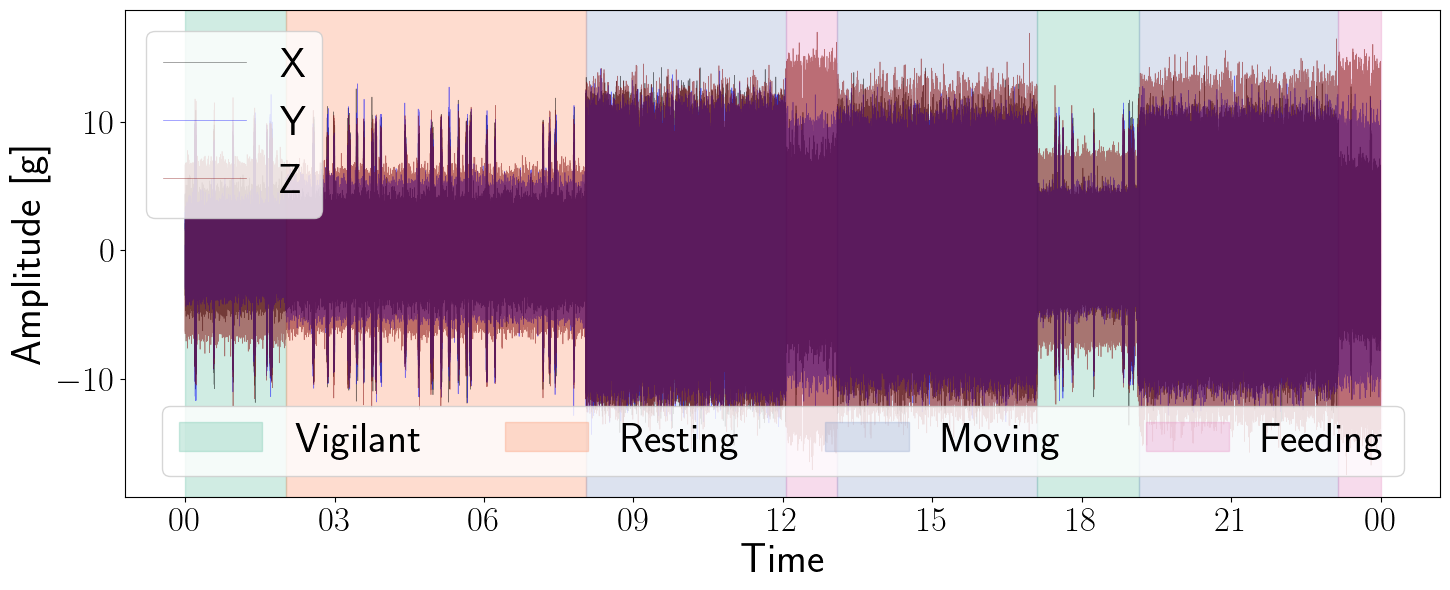

In [26]:
results_dir = os.path.join(config.TEST_ROOT_DIR, "uncertainty_quantification")
acc_df, annotations_df = pd.read_csv(os.path.join(results_dir, 'acc_df.csv')), pd.read_csv(os.path.join(results_dir, 'annotations_df.csv'))

results_dir = os.path.join(config.TEST_ROOT_DIR, "temporal_context")
os.makedirs(results_dir, exist_ok=True)

n_corruptions = 100
min_duration, max_duration = 2*window_length, 4*window_length
pos = np.random.randint(0, len(acc_df)-max_duration, n_corruptions)
durations = np.random.randint(min_duration, max_duration, n_corruptions)

for p, d in zip(pos, durations):
    f, A, phi, sigma = [4,3], [3,4], [3,4], 1.5
    acc_df.loc[p:p+d-1, 'Acc X [g]'] = simulate_axis_signal(f, A, phi, sigma, d, .5)
    acc_df.loc[p:p+d-1, 'Acc Y [g]'] = simulate_axis_signal(f, A, phi, sigma, d, .5)
    acc_df.loc[p:p+d-1, 'Acc Z [g]'] = simulate_axis_signal(f, A, phi, sigma, d, .5)

plot_simulated_day(acc_df, plot_path=os.path.join(results_dir, 'corrupted_signal.png'))

In [27]:
acc_df['Timestamp'] = pd.to_datetime(acc_df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
acc_df.sort_values(by='Timestamp', inplace=True)
signal = torch.tensor(np.array([acc_df['Acc X [g]'].values, acc_df['Acc Y [g]'].values, acc_df['Acc Z [g]'].values])).float().unsqueeze(0)
annotations_df = annotations_df.rename(columns={'Timestamp_start': 'behavior_start', 'Timestamp_end': 'behavior_end', 'Behavior': 'behavior'})

In [44]:
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter


def plot_signal_and_online_predictions(time, signal, online_avg, window_length, hop_length, window_duration, label_encoder, sampling_rate=16, plot_dir=None, half_day_behaviors=None):
    """
    Plots the raw signal and the online predictions.

    Parameters:
    ---------------
    - time: time stamps of the signal (1D array).
    - signal: The raw signal data (1D array).
    - online_avg: The average online prediction probabilities (2D array).
    - window_length: Length of each window for smoothening.
    - hop_length: Overlap length between windows in data points.
    - window_duration: Duration of each window in seconds.
    - label_encoder: A label encoder for behavior labels.
    - sampling_rate: The sampling rate of the signal (Hz).
    - plot_dir: Directory where the plot will be saved. If None, the plot is not saved.
    """
    
    sns.set_style("whitegrid")  # Set seaborn style at the beginning

    time = pd.to_datetime(time)

    # Calculate x-axis in hours
    x = window_duration * (np.arange(online_avg.shape[-1]) * hop_length + window_length / 2) / 3600
    
    # y-axis labels for each row in online_avg
    y = np.arange(online_avg.shape[0])

    # Create a mesh grid for plotting
    X, Y = np.meshgrid(x, y)
    color_intensity = online_avg

    # Flatten the mesh grid and color intensity for scatter plot
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    color_flat = color_intensity.flatten()

    # Get inverse transformed labels for y-axis
    y_labels = label_encoder.inverse_transform(y)

    # Create figure and GridSpec
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[30, 1], height_ratios=[1, 1], wspace=0.2, hspace=0.6)

    # Create subplots
    ax_signal = fig.add_subplot(gs[0, 0])
    ax_online = fig.add_subplot(gs[1, 0])
    cbar_ax = fig.add_subplot(gs[1, 1])

    # Plot the signal
    ax_signal.plot(time, signal[0,0,:], label='X Signal', color='black', linewidth=.5, alpha=0.6)
    ax_signal.plot(time, signal[0,1,:], label='Y Signal', color='blue', linewidth=.5, alpha=0.5)
    ax_signal.plot(time, signal[0,2,:], label='Z Signal', color='maroon', linewidth=.5, alpha=0.4)
    ax_signal.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax_signal.set_xlabel('Time (h)')
    ax_signal.set_ylabel("Amplitude (g)")
    ax_signal.set_title("Raw Signal along X axis")
    

    # Plot behaviors
    if half_day_behaviors is not None:
        colors = dict(zip(config.BEHAVIORS, sns.color_palette("Set2", len(config.BEHAVIORS))))
        for i in range(len(half_day_behaviors)):
            behavior = half_day_behaviors.iloc[i]['behavior']
            ax_signal.axvspan(half_day_behaviors.iloc[i]['behavior_start'], 
                              half_day_behaviors.iloc[i]['behavior_end'], 
                              color=colors[behavior], 
                              alpha=0.3)
    legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[behavior], markersize=10, alpha=0.3, label=behavior)
                  for behavior in label_encoder.classes_]
    ax_signal.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.26, 1.14), fontsize=25)


    # Plot the online predictions
    scatter = ax_online.scatter(X_flat, Y_flat, c=color_flat, cmap='Blues', s=140, marker='s', alpha=0.7)
    ax_online.set_xlabel("Time (h)")
    ax_online.set_yticks(y)
    ax_online.set_yticklabels(y_labels)
    ax_online.set_ylim(-1, len(y))
    ax_online.set_title(f"Online Predictions, $s = {window_length}$")

    xtick_locs = np.arange(0, x.max() + 1, 3)
    xtick_labels = [f"${int(tick % 24):02d}$" for tick in xtick_locs]

    ax_online.xaxis.set_major_locator(FixedLocator(xtick_locs))
    ax_online.xaxis.set_major_formatter(FixedFormatter(xtick_labels))

    # Add colorbar to the scatter plot, placed in the separate axis
    cbar = plt.colorbar(scatter, cax=cbar_ax)
    cbar.set_label('Softmax Score', fontsize=25)

    # Adjust layout to fit everything
    plt.tight_layout(rect=[0, 0, 2.9, 1])  # Reduce right space for colorbar

    # Save plot if plot_dir is specified
    if plot_dir is not None:
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)  # Create directory if it doesn't exist
        plt.savefig(os.path.join(plot_dir, f'window_length_{window_length}.png'), dpi=300)
    
    plt.show()

    return fig, (ax_signal, ax_online)


/tmp/ipykernel_122786/1662700015.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 2.9, 1])  # Reduce right space for colorbar


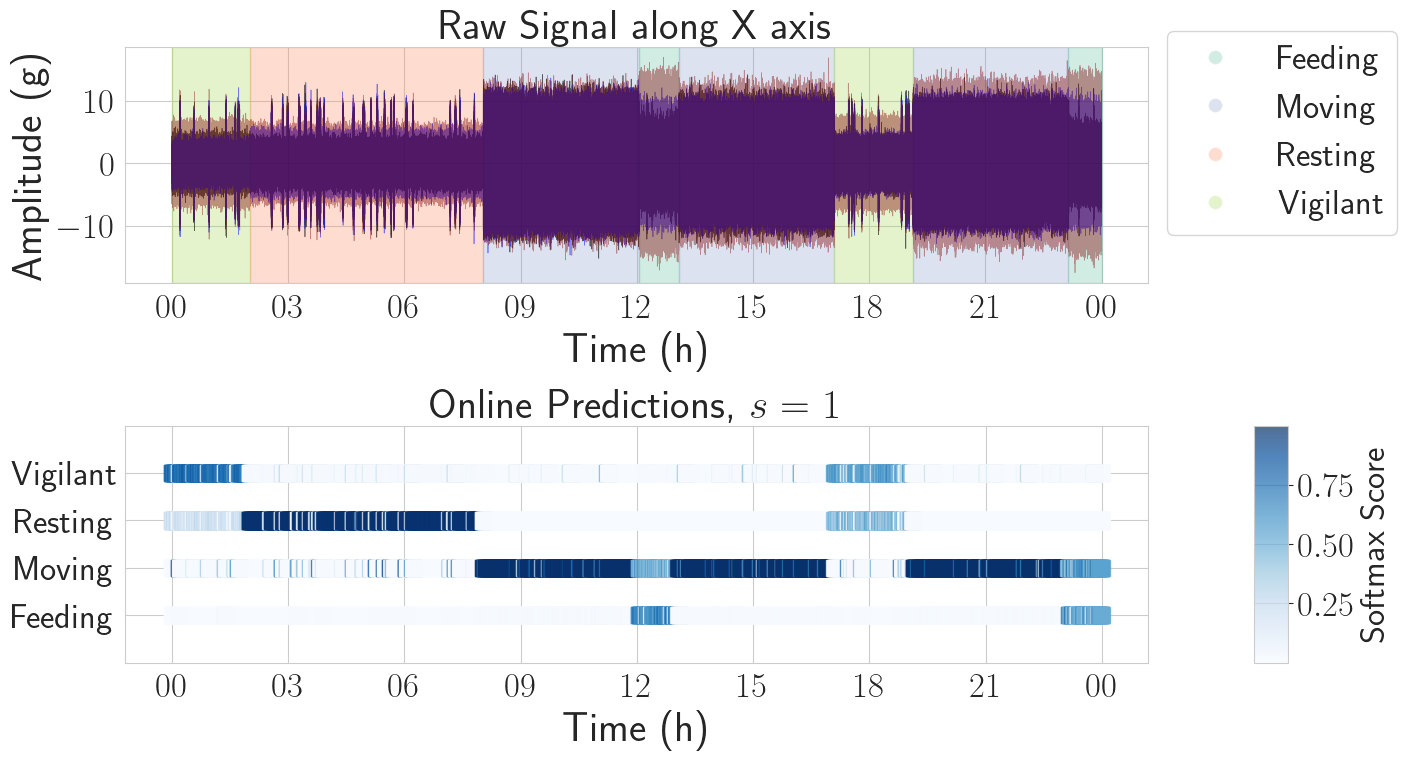

(<Figure size 1500x800 with 3 Axes>,
 (<Axes: title={'center': 'Raw Signal along X axis'}, xlabel='Time (h)', ylabel='Amplitude (g)'>,
  <Axes: title={'center': 'Online Predictions, $s = 1$'}, xlabel='Time (h)'>))

In [45]:
smoothening_config = {'smoothening_window_length': 1,
                          'smoothening_hop_length': 1,
                          'score_hop_length': None
                          }
window_duration = 30.0
scores = online_score_evaluation(model_dir=model_dir, X=signal, window_duration=window_duration, window_length=None, hop_length=smoothening_config['score_hop_length'], sampling_frequency=config.SAMPLING_RATE)
online_avg = online_smoothening(scores, smoothening_config['smoothening_window_length'], smoothening_config['smoothening_hop_length'])
plot_signal_and_online_predictions(
    acc_df['Timestamp'],
    signal, 
    online_avg, 
    smoothening_config['smoothening_window_length'], 
    smoothening_config['smoothening_hop_length'], 
    window_duration, 
    label_encoder, 
    sampling_rate=config.SAMPLING_RATE, 
    plot_dir=results_dir,
    half_day_behaviors=annotations_df
)

/tmp/ipykernel_122786/1662700015.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 2.9, 1])  # Reduce right space for colorbar


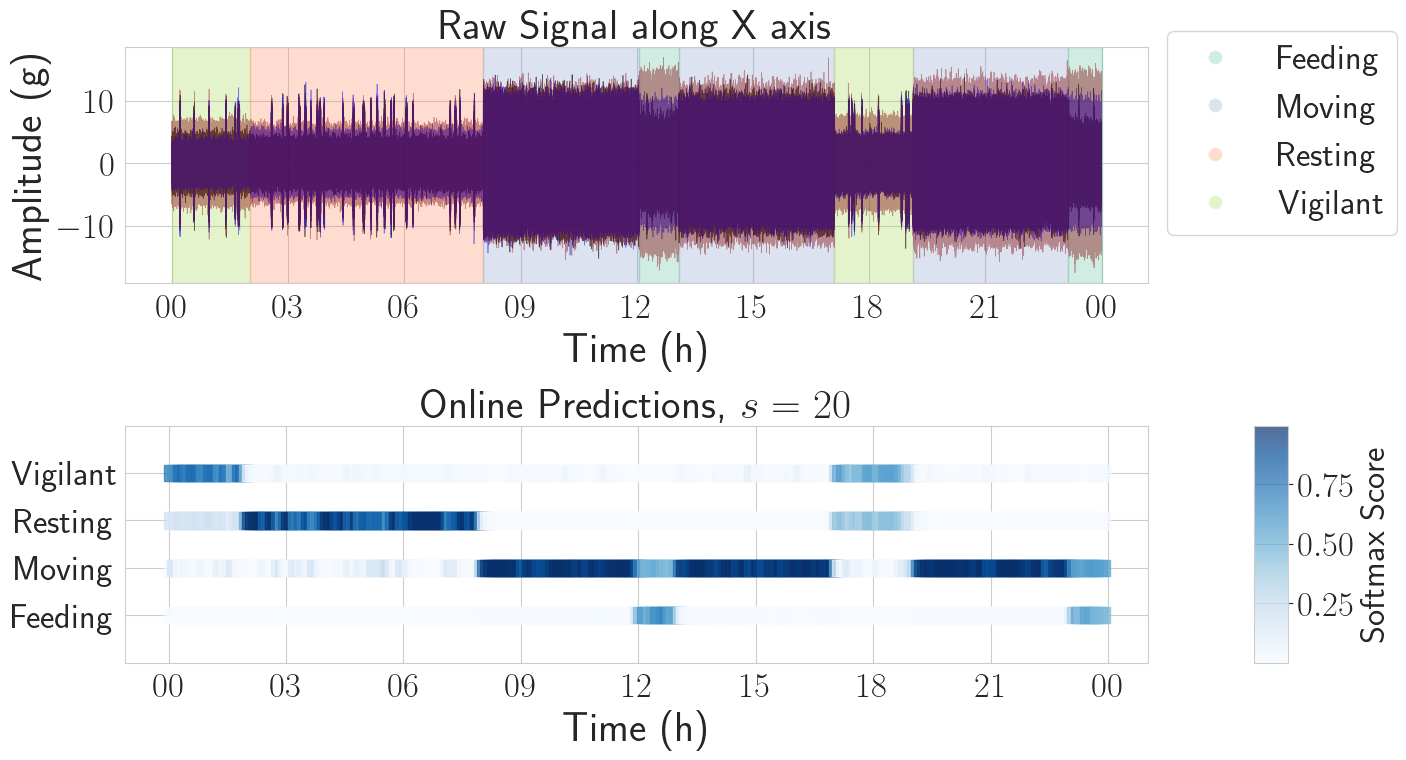

(<Figure size 1500x800 with 3 Axes>,
 (<Axes: title={'center': 'Raw Signal along X axis'}, xlabel='Time (h)', ylabel='Amplitude (g)'>,
  <Axes: title={'center': 'Online Predictions, $s = 20$'}, xlabel='Time (h)'>))

In [46]:
smoothening_config = {'smoothening_window_length': 20,
                          'smoothening_hop_length': 10,
                          'score_hop_length': None
                          }
                          
scores = online_score_evaluation(model_dir=model_dir, X=signal, window_duration=window_duration, window_length=None, hop_length=smoothening_config['score_hop_length'], sampling_frequency=config.SAMPLING_RATE)
online_avg = online_smoothening(scores, smoothening_config['smoothening_window_length'], smoothening_config['smoothening_hop_length'])

plot_signal_and_online_predictions(
    acc_df['Timestamp'],
    signal, 
    online_avg, 
    smoothening_config['smoothening_window_length'], 
    smoothening_config['smoothening_hop_length'], 
    window_duration, 
    label_encoder, 
    sampling_rate=config.SAMPLING_RATE, 
    plot_dir=results_dir,
    half_day_behaviors=annotations_df
)

In [169]:
def get_online_avg_idx(idx, w, h):
    if idx+1 <= w:
        j = 0
    else:
        if (idx+1 - w) % h == 0:
            j = (idx+1 - w)//h
        else:
            j = 1+(idx+1 - w)//h
    return j

scores = scores.reshape(-1, scores.shape[-1])
df_cropped = acc_df.iloc[(len(acc_df) - window_length) % window_length : ].copy().reset_index()
online_avg_threhold = smoothening_config['smoothening_window_length'] + smoothening_config['smoothening_hop_length']*((scores.shape[-1] - smoothening_config['smoothening_window_length']) // smoothening_config['smoothening_hop_length'] )

for _, behavior in enumerate(config.SIM_BEHAVIORS):
    scores_idx = np.unique((df_cropped[df_cropped['Behavior'] == behavior].index.values)//window_length)
    scores_idx = scores_idx[scores_idx < online_avg_threhold]
    online_avg_idx = (np.array([get_online_avg_idx(i, smoothening_config['smoothening_window_length'], smoothening_config['smoothening_hop_length']) for i in scores_idx]))
    print(len(scores_idx), len(np.unique(online_avg_idx)))
    nosmooth_TV = np.round(np.std((np.diff(scores[:, scores_idx], axis=-1)), axis=-1), 4)
    smooth_TV = np.round(np.std((np.diff(online_avg[:,online_avg_idx], axis=-1)), axis=-1), 4)
    print("")
    print(behavior)
    print(f"{'No Smooth TV':<15} {nosmooth_TV} | {'Smooth TV':<10} {smooth_TV}")

118 13

Feeding
No Smooth TV    [0.2592 0.2435 0.0005 0.0015] | Smooth TV  [0.0437 0.0398 0.     0.0001]
1073 108

Moving
No Smooth TV    [0.0387 0.0588 0.0002 0.0021] | Smooth TV  [0.0176 0.0316 0.0252 0.0003]
1444 147

Resting
No Smooth TV    [0.0024 0.1554 0.1809 0.0126] | Smooth TV  [0.0001 0.0317 0.0384 0.0107]
241 24

Vigilant
No Smooth TV    [0.0003 0.1362 0.1149 0.1553] | Smooth TV  [0.     0.0187 0.0219 0.0239]


## Result 4: Distribution Shift

In [63]:
from src.utils.simulations import generate_dataset, compute_features, energy_distance
from sklearn.model_selection import train_test_split
import ot
from sklearn.preprocessing import StandardScaler

import yaml

In [64]:
# experiment paths

results_dir = os.path.join(config.TEST_ROOT_DIR, "distribution_shift")
os.makedirs(results_dir, exist_ok=True)

# training results path
training_results_dir = os.path.join(results_dir, "training_results")
os.makedirs(training_results_dir, exist_ok=True)

# plots
plots_dir = os.path.join(results_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

In [65]:
def get_test_data_constants(train_data_constants, eps):
    """
    Applies soft interpolation to f, A, and sigma values in train_data_constants
    based on behavior groups and returns a transformed copy.
    """
    # Define constants
    behaviors1_f, behaviors1_A, behaviors1_sigma = 3.5, 3.5, 1.0
    behaviors2_f, behaviors2_A, behaviors2_sigma = 1.5, 1.5, 0.2

    # Define transformation function
    transform_fn = lambda x, eps, x_hat: (1 - eps) * x + eps * x_hat

    df = train_data_constants.copy()

    # Mask for each group
    mask1 = df['Behavior'].isin(['Feeding', 'Moving'])
    mask2 = df['Behavior'].isin(['Resting', 'Vigilant'])

    # Apply transformation to each column and group
    for col, x_hat1, x_hat2 in [('f', behaviors1_f, behaviors2_f),
                                ('A', behaviors1_A, behaviors2_A)]:
        df.loc[mask1, col] = df.loc[mask1, col].apply(lambda tup: tuple(transform_fn(x, eps, x_hat1) for x in tup))
        df.loc[mask2, col] = df.loc[mask2, col].apply(lambda tup: tuple(transform_fn(x, eps, x_hat2) for x in tup))

    # Apply transformation to 'sigma'
    df.loc[mask1, 'sigma'] = df.loc[mask1, 'sigma'].apply(lambda x: transform_fn(x, eps, behaviors1_sigma))
    df.loc[mask2, 'sigma'] = df.loc[mask2, 'sigma'].apply(lambda x: transform_fn(x, eps, behaviors2_sigma))

    return df


In [66]:
train_data_constants = config.SIMULATION_CONSTANTS

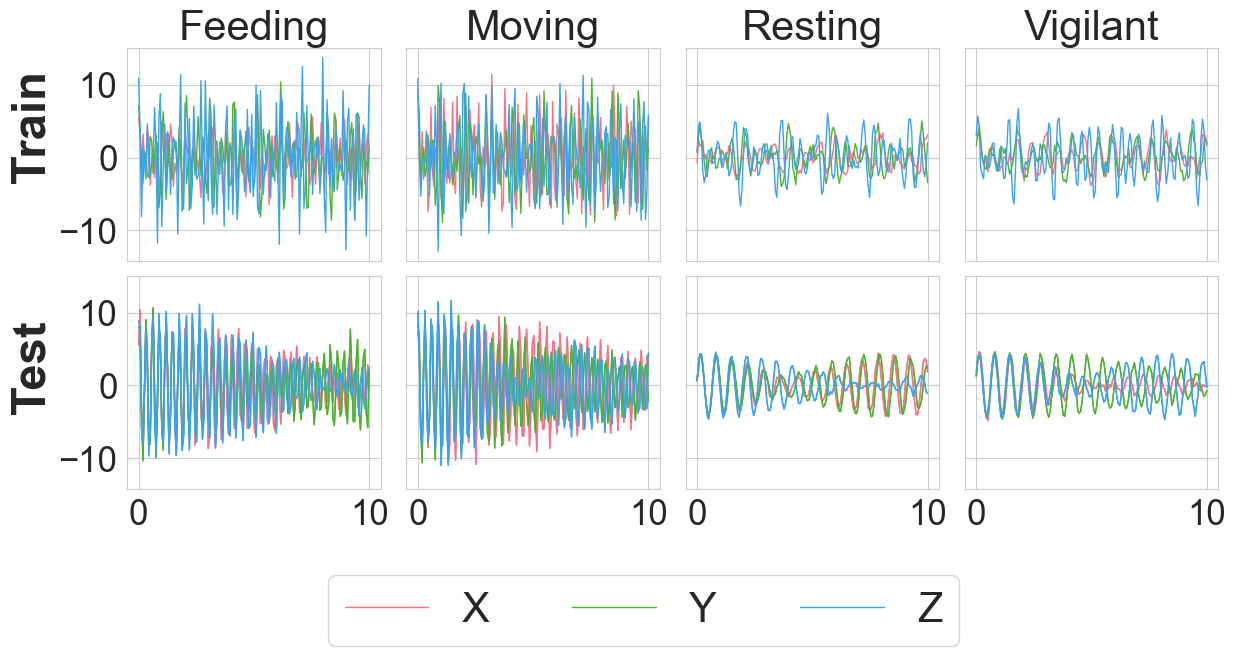

In [67]:
t = np.linspace(0, 10, 160)
fig, axs = plt.subplots(2, len(config.SIM_BEHAVIORS), figsize=(3*len(config.SIM_BEHAVIORS), 6), sharey=True, sharex=True)
color_palette = sns.color_palette("husl", 3)

test_data_constants = get_test_data_constants(train_data_constants, 1.0)

for i, observed_behavior in enumerate(config.SIM_BEHAVIORS):

    # Train 
    for j, axis in enumerate(['X', 'Y', 'Z']):

        f, A, phi, sigma = train_data_constants.loc[(train_data_constants["Behavior"] == observed_behavior) & (train_data_constants["Axis"] == axis), ['f', 'A', 'phi', 'sigma']].values[0]
        signal = simulate_axis_signal(list(f), list(A), list(phi), sigma, len(t),) #simulate_fourier_signal(list(f_X), list(A_X), list(phi_X), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
        axs[0, i].plot(t, signal, color=color_palette[j], linewidth=1)

    axs[0, i].set_title(observed_behavior)

    # Test
    for j, axis in enumerate(['X', 'Y', 'Z']):

        f, A, phi, sigma = test_data_constants.loc[(test_data_constants["Behavior"] == observed_behavior) & (test_data_constants["Axis"] == axis), ['f', 'A', 'phi', 'sigma']].values[0]
        signal = simulate_axis_signal(list(f), list(A), list(phi), sigma, len(t)) #simulate_fourier_signal(list(f_X), list(A_X), list(phi_X), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
        axs[1, i].plot(t, signal, color=color_palette[j], linewidth=1)

        if i == 0:
            axs[1, i].plot(t, signal, label=axis, color=color_palette[j], linewidth=1)
        else:
            axs[1, i].plot(t, signal, color=color_palette[j], linewidth=1)

fig.text(-0.01, 0.7, 'Train', ha='center', va='center', fontsize=34, fontweight='bold', rotation=90)
fig.text(-0.01, 0.3, 'Test', ha='center', va='center', fontsize=34, fontweight='bold', rotation=90)

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2))
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space at the top for titles
plt.savefig(os.path.join(plots_dir, 'distribution_shift-raw_signals.pdf'))
plt.show()


In [68]:
# train_class_dist = dict(zip(config.SIM_BEHAVIORS, [0.05, 0.2, 0.4, 0.35]))
# test_class_dist = dict(zip(config.SIM_BEHAVIORS, [0.05, 0.2, 0.4, 0.35]))

train_class_dist = class_dist
test_class_dist = class_dist

window_length = int(30.0 * config.SAMPLING_RATE)
n_train, n_test = 4000, 6000

label_encoder = LabelEncoder()
label_encoder.fit(config.SIM_BEHAVIORS)

LabelEncoder()

In [69]:
args.theta = 0.8
eps_list = np.round(np.linspace(0, 1, 11), 1)

In [70]:
# train the CNN model on a fixed train set 
test_data_constants = get_test_data_constants(train_data_constants, 0.0)

# train and test set
X_train, y_train = generate_dataset(train_data_constants, train_class_dist, window_length, n_train, wrong_behavior=True, wrong_behavior_prob=0.1, tau=0.4)
X_test, y_test = generate_dataset(test_data_constants, test_class_dist, window_length, n_test, tau=0.4)

scaler = StandardScaler()
X_train_features = compute_features(X_train)
X_train_features = scaler.fit_transform(X_train_features)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)
n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(y_train))
y_train, y_val, y_test = label_encoder.transform(y_train), label_encoder.transform(y_val), label_encoder.transform(y_test)

train_dataloader, val_dataloader, test_dataloader = utils_data.setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# Define the sequential model
model = create_dynamic_conv_model(n_features, n_timesteps, n_outputs, 
                                        num_conv_layers=args.n_CNNlayers, 
                                        base_channels=args.n_channels, 
                                        kernel_size=args.kernel_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

#### Training
train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, args, device)
model = train_obj['model']
training_stats = train_obj['training_stats']

model_dir = training_results_dir
os.makedirs(model_dir, exist_ok=True)

torch.save(model, os.path.join(model_dir, 'model.pt'))
json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
with open(json_training_stats_file, 'w') as f:
    json.dump(training_stats, f)

# save true and predicted validation classes along with val metadata
np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])


Epoch 100/100 | Train Loss: 0.0559 | Val Loss: 0.1115 | Best val Loss: 0.1058: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]

Total training time: 0:00:27


In [71]:
eps_list = np.round(np.linspace(0, 1, 11), 1)

for i, eps in enumerate(eps_list):

    test_data_constants = get_test_data_constants(train_data_constants=train_data_constants, eps=eps)
    X_test, y_test = generate_dataset(test_data_constants, test_class_dist, window_length, n_test)
    
    X_test_features = compute_features(X_test)
    X_test_features = scaler.transform(X_test_features)

    ot_value = np.round(ot.sliced_wasserstein_distance(X_train_features, X_test_features, n_projections=100), 4)
    print(f"{'eps:':<5} {eps} | {'OT distance:':<10} {ot_value} ")

    train_test_dist = {'ot': ot_value}

    y_test = label_encoder.transform(y_test)
    model_dir = os.path.join(training_results_dir, f'eps{eps}')
    os.makedirs(model_dir, exist_ok=True)

    outputs = model(torch.Tensor(X_test).to(device))
    predictions_test = torch.argmax(outputs, dim=1).cpu().numpy()

    # save true and predicted test classes 
    np.save(os.path.join(model_dir, 'test_true_classes.npy'), y_test)
    np.save(os.path.join(model_dir, 'test_predictions.npy'),  predictions_test)

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
    np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])

    with open(os.path.join(model_dir, 'train_test_dist.pkl'), 'wb') as f:
        pickle.dump(train_test_dist, f)

eps:  0.0 | OT distance: 0.1286 | Energy distance: 0.0441
eps:  0.1 | OT distance: 0.1568 | Energy distance: 0.0796
eps:  0.2 | OT distance: 0.2001 | Energy distance: 0.1298
eps:  0.3 | OT distance: 0.2278 | Energy distance: 0.225
eps:  0.4 | OT distance: 0.3151 | Energy distance: 0.3472
eps:  0.5 | OT distance: 0.345 | Energy distance: 0.4683
eps:  0.6 | OT distance: 0.3977 | Energy distance: 0.6538
eps:  0.7 | OT distance: 0.4798 | Energy distance: 0.7999
eps:  0.8 | OT distance: 0.5714 | Energy distance: 1.0272
eps:  0.9 | OT distance: 0.8774 | Energy distance: 1.6522
eps:  1.0 | OT distance: 1.2908 | Energy distance: 3.9745


In [72]:
eps_list = np.round(np.linspace(0, 1, 11), 1)

exp_results = {'ot': np.zeros(len(eps_list)),
               'energy': np.zeros(len(eps_list)),
               'precision': np.zeros(len(eps_list)),
               'recall': np.zeros(len(eps_list)),
               'f1_score': np.zeros(len(eps_list))}

for i, eps in enumerate(eps_list):

    model_dir = os.path.join(training_results_dir, f'eps{eps}')

    with open(os.path.join(model_dir, 'train_test_dist.pkl'), 'rb') as f:
        train_test_dist = pickle.load(f)

    exp_results['ot'][i] = train_test_dist['ot']
    exp_results['energy'][i] = train_test_dist['energy']
    exp_results['precision'][i] = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average='macro'), 4)
    exp_results['recall'][i] = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average='macro'), 4)
    exp_results['f1_score'][i] = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average='macro'), 4)   

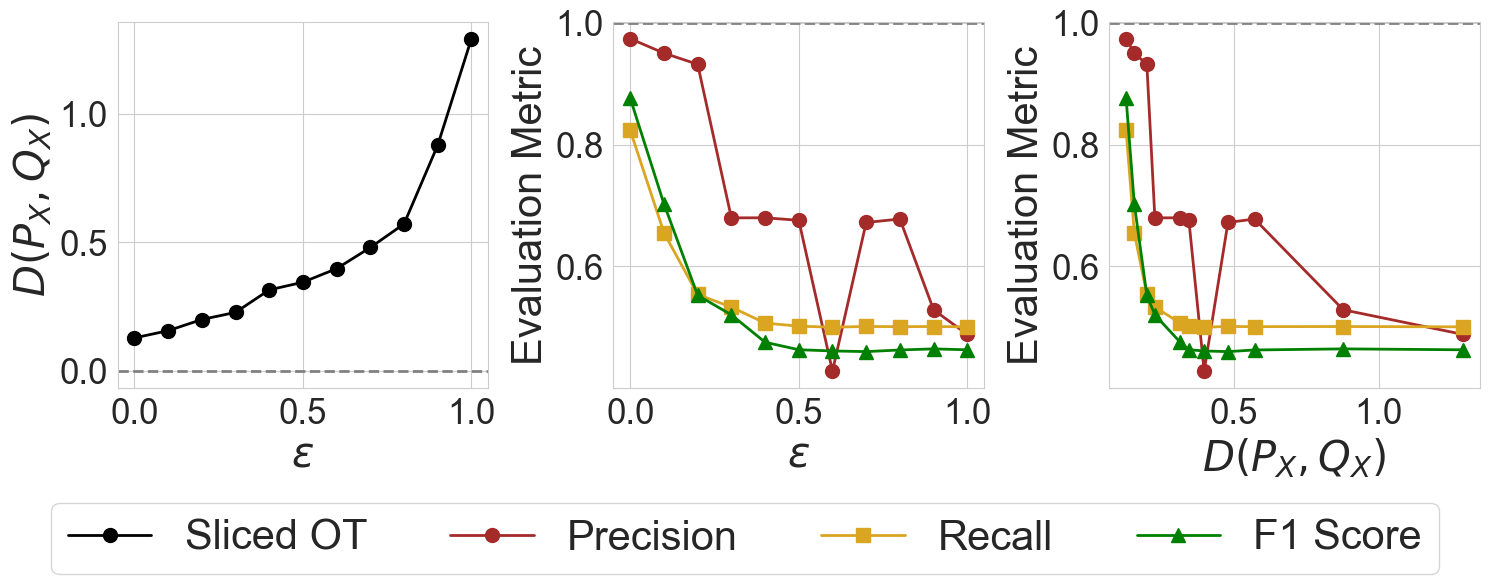

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(eps_list, exp_results['ot'], marker = 'o', color='black', markersize=10, label='Sliced OT')
# axs[0].plot(eps_list, exp_results['energy'], marker = 's', color='black', markersize=10, label='Energy')
axs[0].axhline(y=0.0, color='grey', linestyle='--')
axs[0].set_xlabel(r"$\varepsilon$")
axs[0].set_ylabel(r"$D(P_X, Q_X)$")

axs[1].plot(eps_list, exp_results['precision'], marker = 'o', color='brown', markersize=10, label='Precision')
axs[1].plot(eps_list, exp_results['recall'], marker = 's', color='goldenrod', markersize=10, label = 'Recall')
axs[1].plot(eps_list, exp_results['f1_score'], marker = '^', color='green', markersize=10, label='F1 Score')
axs[1].set_xlabel(r"$\varepsilon$")
axs[1].set_ylabel("Evaluation Metric")
axs[1].axhline(y=1.0, color='grey', linestyle='--')

axs[2].plot(exp_results['ot'], exp_results['precision'], marker = 'o', color='brown', markersize=10)
axs[2].plot(exp_results['ot'], exp_results['recall'], marker = 's', color='goldenrod', markersize=10)
axs[2].plot(exp_results['ot'], exp_results['f1_score'], marker = '^', color='green', markersize=10)
axs[2].set_xlabel(r"$D(P_X, Q_X)$")
axs[2].set_ylabel("Evaluation Metric")
axs[2].axhline(y=1.0, color='grey', linestyle='--')

# Create a common legend
handles, labels = [], []
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.2), bbox_transform=fig.transFigure)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'distribution_shift-performance_decay.png'), dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

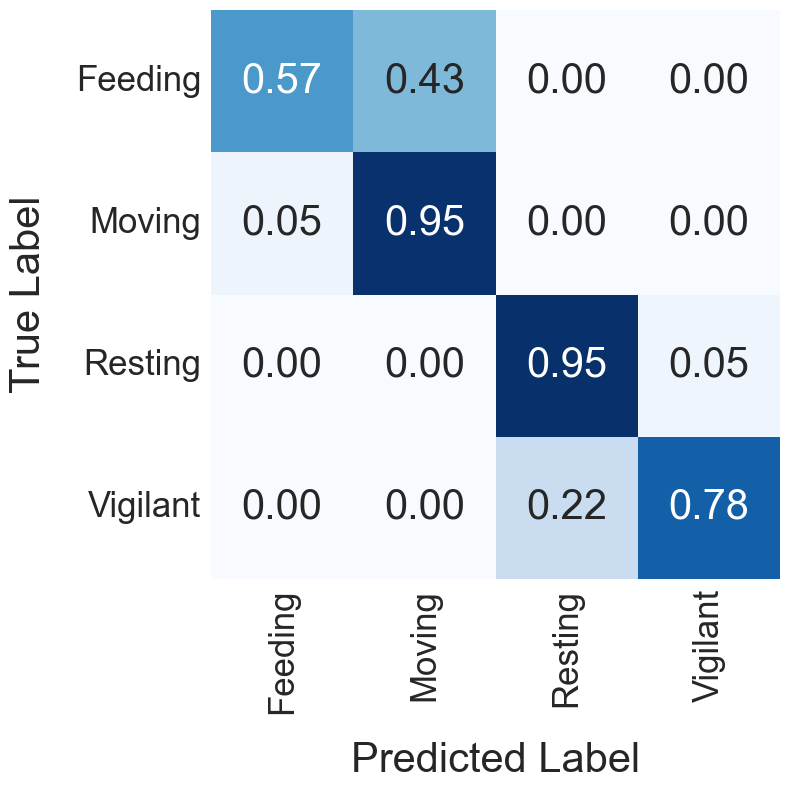

In [74]:
eps=0.0
model_dir = os.path.join(training_results_dir, f"eps{eps}")
multi_label_predictions(model_dir, 
                        label_encoder, 
                        split='val', 
                        plot_confusion=True, 
                        return_accuracy=False, 
                        plot_path=os.path.join(plots_dir, 'distribution_shift-val_confusion.pdf'))

<Figure size 640x480 with 0 Axes>

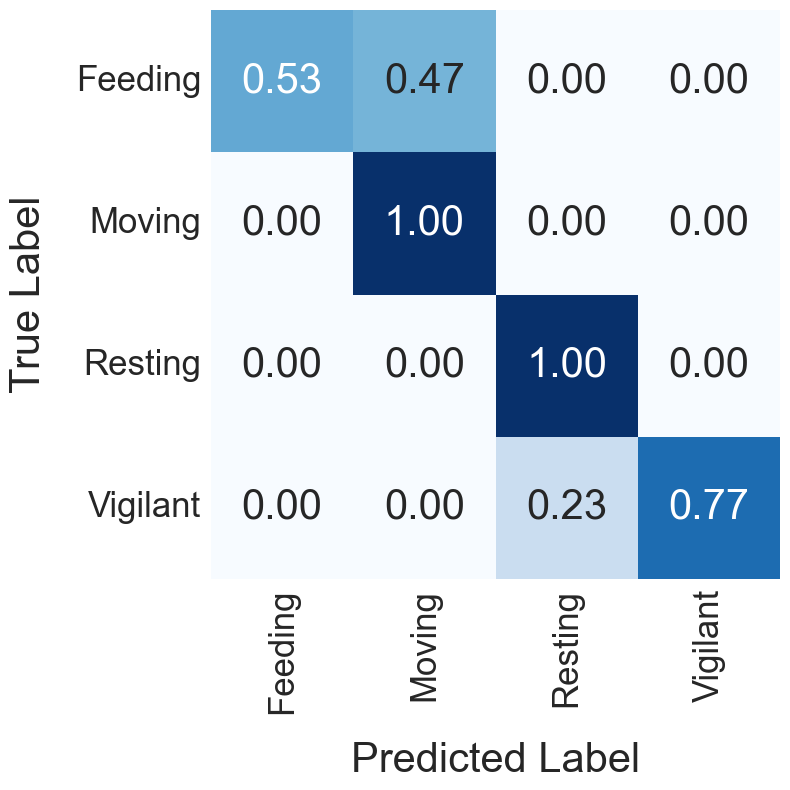

In [75]:
eps=0.0
model_dir = os.path.join(training_results_dir, f"eps{eps}")
multi_label_predictions(model_dir, 
                        label_encoder, 
                        split='test', 
                        plot_confusion=True, 
                        return_accuracy=False, 
                        plot_path=os.path.join(plots_dir, 'distribution_shift-test_confusion_eps0.1.png'))

<Figure size 640x480 with 0 Axes>

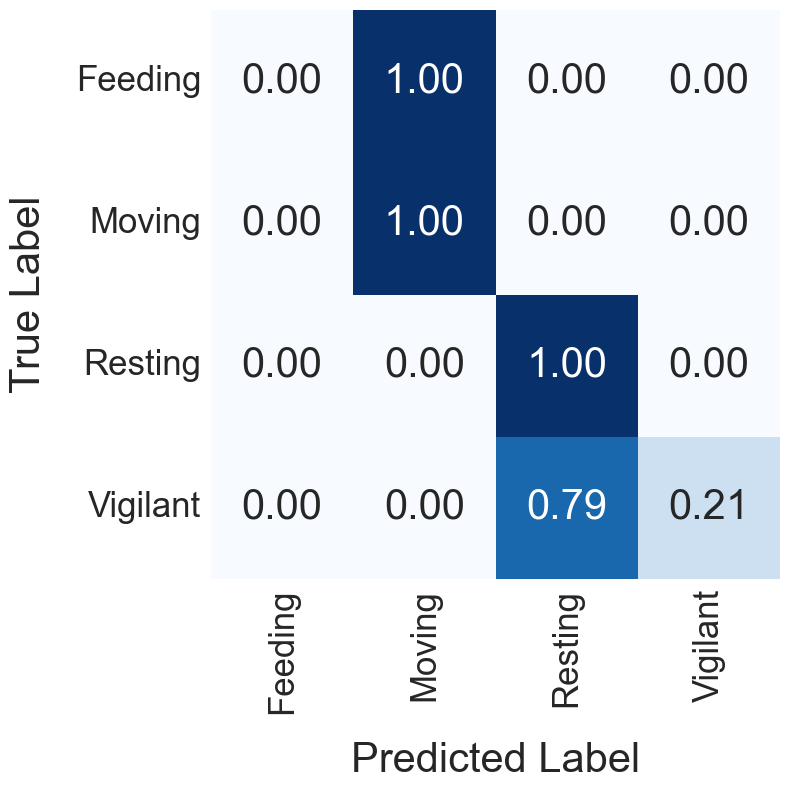

In [76]:
eps=0.2
model_dir = os.path.join(training_results_dir, f"eps{eps}")
multi_label_predictions(model_dir, 
                        label_encoder, 
                        split='test', 
                        plot_confusion=True, 
                        return_accuracy=False, 
                        plot_path=os.path.join(plots_dir, 'distribution_shift-test_confusion_eps0.2.png'))

<Figure size 640x480 with 0 Axes>

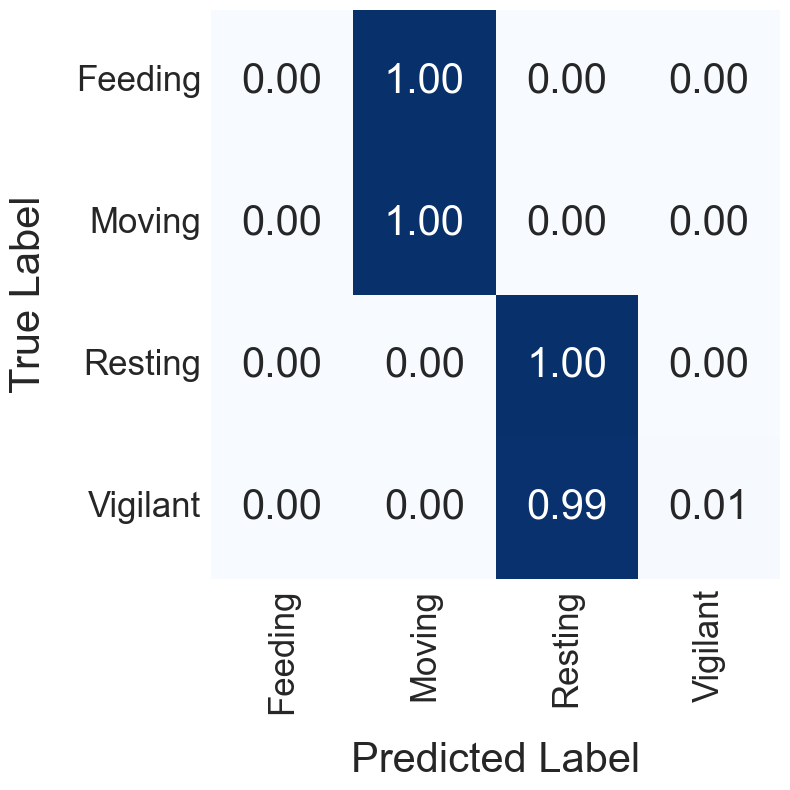

In [77]:
eps=0.5
model_dir = os.path.join(training_results_dir, f"eps{eps}")
multi_label_predictions(model_dir, 
                        label_encoder, 
                        split='test', 
                        plot_confusion=True, 
                        return_accuracy=False, 
                        plot_path=os.path.join(plots_dir, 'distribution_shift-test_confusion_eps0.5.png'))